In [1]:
import pandas as pd
from sklearn import svm
import numpy as np

import matplotlib.pyplot as plt
import waterfall_chart

from scipy.spatial import distance
import itertools

from sklearn.linear_model import LinearRegression

Wczytywanie danych...

In [3]:
data = pd.read_stata('data.dta')

import pandas as pd
from sklearn import svm
import numpy as np

import matplotlib.pyplot as plt
import waterfall_chart

In [4]:
prepared_columns = ['S1','ppincimp', 'partyid7', 'ppwork', 'Q6A']
data_in = data[prepared_columns]

## Tworzenie słownika 
W związku z dużą liczbą kategorii w niektorych zmiennych utworzony został słownik z kategorami i odpowiadającymi im nazwami.

In [5]:
categories_dict = {}
for col in data_in.columns:
    categories_dict[col] = dict(enumerate(data_in.loc[:, col].cat.categories))

categories_dict

{'S1': {0: 'Yes, I am Married', 1: 'No, I am not Married'},
 'ppincimp': {0: 'Less than $5,000',
  1: '$5,000 to $7,499',
  2: '$7,500 to $9,999',
  3: '$10,000 to $12,499',
  4: '$12,500 to $14,999',
  5: '$15,000 to $19,999',
  6: '$20,000 to $24,999',
  7: '$25,000 to $29,999',
  8: '$30,000 to $34,999',
  9: '$35,000 to $39,999',
  10: '$40,000 to $49,999',
  11: '$50,000 to $59,999',
  12: '$60,000 to $74,999',
  13: '$75,000 to $84,999',
  14: '$85,000 to $99,999',
  15: '$100,000 to $124,999',
  16: '$125,000 to $149,999',
  17: '$150,000 to $174,999',
  18: '$175,000 to $199,999',
  19: '$200,000 to $249,999',
  20: '$250,000 or more'},
 'partyid7': {0: 'Strong Republican',
  1: 'Not Strong Republican',
  2: 'Leans Republican',
  3: 'Undecided/Independent/Other',
  4: 'Leans Democrat',
  5: 'Not Strong Democrat',
  6: 'Strong Democrat'},
 'ppwork': {0: 'Working - as a paid employee',
  1: 'Working - self-employed',
  2: 'Not working - on temporary layoff from a job',
  3: 'Not 

In [6]:
data_in = data_in.dropna()
data_in.shape

(2856, 5)

## Transformacja zmiennych

In [7]:
y = data_in['S1'].cat.codes
X = data_in.iloc[:, 1:].apply(lambda x: x.cat.codes, axis=0)

## Utworzenie modelu

In [8]:
X.values

array([[17,  1,  6,  1],
       [19,  4,  0,  1],
       [18,  6,  0,  1],
       ...,
       [16,  5,  0,  1],
       [12,  4,  0,  1],
       [10,  4,  0,  1]], dtype=int8)

In [9]:
svm_model = svm.SVC(gamma=0.01, probability=True)
svm_model.fit(X.values, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Zostały utworzone trzy funkcje w tym jedna główna (<u>ceteris_paribus_plot</u>). 

Funkcja ceteris_paribus_plot przyjmuje następujące argumenty:
1. model - model, który zostanie wyjaśniony
1. row - którą obserwację będziemy uznawać za "bazową"
1. test_x - dane do modelu
1. random - zmienna określająca czy wybór obserwacji "bazowej" ma nastąpić w sposób losowy
1. col - kolumna do wyjaśnienia
1. categories_dict - słownik z kategoriami w zmiennych

In [10]:
def ceteris_paribus_plot(model, row: int, test_x: pd.DataFrame, random: bool, col: str, categories_dict: dict):
    if random:
        selected_observation = test_x.iloc[np.random.randint(1, len(test_x)), :]
    else:
        selected_observation = test_x.iloc[row, :]
        
    possible_values = sorted(test_x[col].unique())
    probabilities = create_probabilities(model, selected_observation, col, possible_values)
    
    create_plot(possible_values, probabilities, col)
    print(categories_dict[col])
    
    
def create_probabilities(model, test_x, col, possible_values):
    probas = []
    for i in possible_values:
        test_x[col] = i
        probas.append(model.predict_proba([test_x.values])[0][0])
    
    return probas


def create_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'Ceteris Paribus plot for {col}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()
    
    
def pd_plot(model, test_x, col):
    values_range = list(np.sort(test_x[col].unique()))
    prob_dict = {}
    for value in values_range:
        temp = test_x.copy()
        temp[col] = value
        pred = temp.apply(lambda row: model.predict_proba([row.values])[0][0], axis=1)
        prob_dict[value] = np.mean(pred)
        
    create_pd_plot(prob_dict.keys(), prob_dict.values(), col)

def create_pd_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'pd_plot for {col}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()
    

def m_plot(model, test_x, col):
    tt = test_x.copy()
    values_range = list(np.sort(test_x[col].unique()))
    tt['pred'] = tt.apply(lambda row: model.predict_proba([row.values])[0][0], axis=1)
    prob_dict = {}
    for value in values_range:
        temp = tt[tt[col] == value]
        prob_dict[value] = np.mean(temp.pred)
        
    create_m_plot(prob_dict.keys(), prob_dict.values(), col)

    
def create_m_plot(possible_values, probabilities, col):
    plt.plot(possible_values, probabilities, marker='o', linestyle='--', color='b')
    plt.title(f'M_plot for {col}')
    plt.ylabel("Probability")
    plt.xlabel(f'{col}')
    plt.show()

Przeanalizowano wpływ zmiennej związanej z dochodem w gospodarstwie. Jak widać im więcej dochodu w gospodastwie tym większe prawdopodobieństwo, że osoba jest w związku małżeńskim.

Wariancja zmienne sugeruje, że zmienna ta jest istotna w modelu.

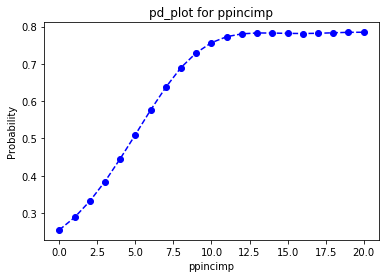

In [11]:
pd_plot(svm_model, X, 'ppincimp')

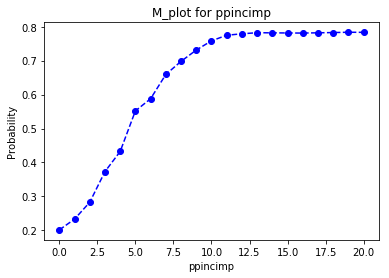

In [12]:
m_plot(svm_model, X, 'ppincimp')

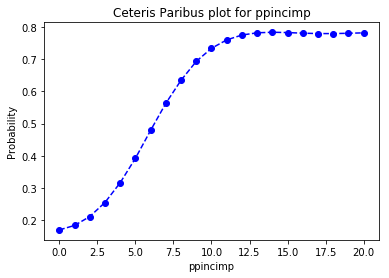

{0: 'Less than $5,000', 1: '$5,000 to $7,499', 2: '$7,500 to $9,999', 3: '$10,000 to $12,499', 4: '$12,500 to $14,999', 5: '$15,000 to $19,999', 6: '$20,000 to $24,999', 7: '$25,000 to $29,999', 8: '$30,000 to $34,999', 9: '$35,000 to $39,999', 10: '$40,000 to $49,999', 11: '$50,000 to $59,999', 12: '$60,000 to $74,999', 13: '$75,000 to $84,999', 14: '$85,000 to $99,999', 15: '$100,000 to $124,999', 16: '$125,000 to $149,999', 17: '$150,000 to $174,999', 18: '$175,000 to $199,999', 19: '$200,000 to $249,999', 20: '$250,000 or more'}


In [13]:
ceteris_paribus_plot(svm_model, 100, X, True, 'ppincimp', categories_dict)

Druga zmienna oznacza preferencje polityczne. Zmienna tak - jak wynika z wykresu - prawdopodobnie nie ogrywa znaczącej roli w modelu.

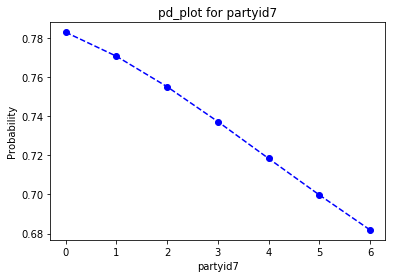

In [14]:
pd_plot(svm_model, X, 'partyid7')

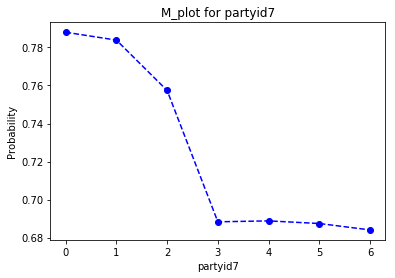

In [15]:
m_plot(svm_model, X, 'partyid7')

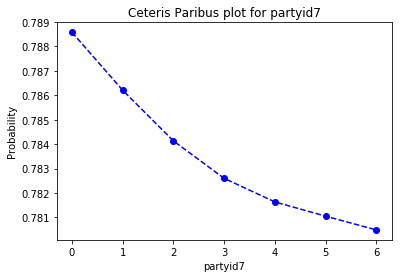

{0: 'Strong Republican', 1: 'Not Strong Republican', 2: 'Leans Republican', 3: 'Undecided/Independent/Other', 4: 'Leans Democrat', 5: 'Not Strong Democrat', 6: 'Strong Democrat'}


In [16]:
ceteris_paribus_plot(svm_model, 100, X, True, "partyid7", categories_dict)

Wykresy oparte na metodzie Ceteris Paribus oraz M_plot nie różnią się w wielki sposób, choć wykazują pewne różnice. Marginal Plot biorący pod uwagę lokalne wartości oczekiwane predykcji, są w pewnych obszarach zgoła inne aniżeli Ceteris Paribus Plots czy PD plots. Również są mniej gładkie. Wynikać to może z obliczenia lokalnych, a nie globalnych prawdopodobieństw i rozbicia naszej populacji na mniejsze podpopulacje podobne do siebie w pewnym względzie (w pewnej zmiennej).

Teraz zajmiemy się kolejnym sposobem interpretacji modelu.

In [17]:
def cond_expect(model, df, observation: dict):
    prediction_exp = {}
    result = {}
    pred = model.predict_proba(df.values)
    pred = [x[1] for x in pred]
    result['all'] = np.mean(pred)
    temp = df.copy()
    
    for k, v in observation.items():    
        temp[k] = v
        pred = model.predict_proba(temp.values)
        pred = [x[1] for x in pred]
        prediction_exp[k] = np.mean(pred)
        print(np.mean(pred))
        
    for k, v in prediction_exp.items():
        result[k] = v - result['all']
    
    return result

In [18]:
observation1 = {'ppincimp': 12, 'partyid7': 6, 'ppwork': 4, 'Q6A': 1}
observation2 = {'partyid7': 6, 'ppincimp': 12, 'Q6A': 1, 'ppwork': 4}

In [19]:
first = cond_expect(svm_model, X, observation1)
second = cond_expect(svm_model, X, observation2)

0.21970311285140362
0.2368108851128416
0.20751696546846363
0.2073184161154918
0.31815455290520916
0.2368108851128416
0.2370255014945565
0.2073184161154918


In [20]:
first

{'all': 0.2731882064885989,
 'ppincimp': -0.05348509363719525,
 'partyid7': -0.03637732137575728,
 'ppwork': -0.06567124102013525,
 'Q6A': -0.06586979037310708}

In [21]:
second

{'all': 0.2731882064885989,
 'partyid7': 0.04496634641661029,
 'ppincimp': -0.03637732137575728,
 'Q6A': -0.036162704994042366,
 'ppwork': -0.06586979037310708}

Z wyników wynika, że występuje interakcja między zmiennymi ppincimp oraz partyid7. W przypadku warunkowania w pierwszym kroku po 'ppincimp' zmienna 'partyid7' wpływa negatywnie na 'niebycie' w małżeństwie (0 - Yes, I am married; 1 - No, I am not). Jeżeli natomiast zmienimy kolejność warunkowania, zmienna 'partyid7' będzie wpływała poztywnie. Oznacza to, że kolejność warunkowania istotnie wpływa na wyniki metody Break Down. W przypadku pozostałych zmiennych nie widać dużej zmiany, chociaż aby jednoznacznie udzielić odpowiedzi, powinniśmy powtórzyć operację na wszystkich permutacjach zmiennych. Widać jednak, że kończowy rezultat istotnie różni się w obu przypadkach. Wyraźniej pokazują to poniższe wykresy.

<module 'matplotlib.pyplot' from 'C:\\Users\\LipaM\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

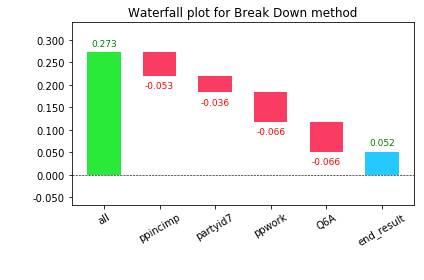

In [22]:
waterfall_chart.plot(list(first.keys()), list(first.values()), formatting='{:.3f}',
                    net_label='end_result', Title='Waterfall plot for Break Down method')

<module 'matplotlib.pyplot' from 'C:\\Users\\LipaM\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

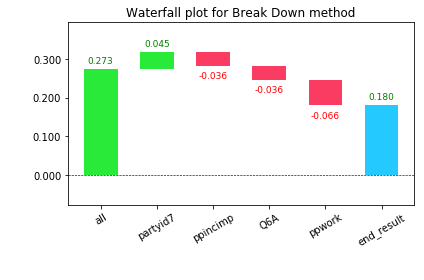

In [23]:
waterfall_chart.plot(list(second.keys()), list(second.values()), formatting='{:.3f}',
                    net_label='end_result', Title='Waterfall plot for Break Down method')

In [24]:
def cartesian_lime(model, df: pd.DataFrame, observation: list, similarity_perc):
    df['distance'] = df.apply(lambda x: distance.euclidean(x, observation), axis=1)
    
    n = int(np.floor(similarity_perc*len(df)))
    data = (df.sort_values('distance').drop_duplicates()).iloc[:n, :-1]
    
    vals = {}
    for i in range(len(data.columns)):
        vals[data.columns[i]] = list(data.iloc[:, i].unique())
        
    cart_df = pd.DataFrame(list(itertools.product(*vals.values())), columns=vals.keys())
    
    cart_df['pred'] = cart_df.apply(lambda x: model.predict_proba([x.values]), axis=1)
    cart_df['pred'] = cart_df.pred.apply(lambda x: x[0][1])
    
    cart_df['distance'] = cart_df.apply(lambda x: distance.euclidean(x[0:4], observation), axis=1)
    
    WLS = LinearRegression()
    WLS.fit(cart_df.iloc[:, :4], cart_df.loc[:, 'pred'], sample_weight=cart_df.loc[:, 'distance'])
    
    print(f'Interception: {WLS.intercept_}')
    for i in range(len(WLS.coef_)):
        print(f'{cart_df.columns[i]}: {WLS.coef_[i]}')
    return WLS

In [25]:
observation = [12, 6, 4, 1]
mm = cartesian_lime(svm_model, X, observation, 0.1)

Interception: 0.2927068078350862
ppincimp: -0.006220352492682353
partyid7: 0.014719379884866286
ppwork: -0.010187558611864232
Q6A: -0.0011939716271241142


In [26]:
first

{'all': 0.2731882064885989,
 'ppincimp': -0.05348509363719525,
 'partyid7': -0.03637732137575728,
 'ppwork': -0.06567124102013525,
 'Q6A': -0.06586979037310708}

Teraz możemy porównać metodę LIME z kartezjańską perturbacją oraz metodę Break Dow. Znak we wpływie poszczególnych zmiennych na predykcję różni się tylko w przypadku zmiennej partyid7, chociaż jak pokazuje przykład z zeszłej pracy domowej inna permutacja kolumn wywołała dodatni wpływ tej zmiennej na predykcję w modelu. Jednak same wartości bezwzględne różnią sie znacząco. Nie do końca wiadomo czy jest to spowodowane metodą LIME czy dość niestandardową metodą perturbacji danych polegającą na wzięcie iloczynu kartezjańskiego obserwacji najbardziej podobnych do badanej obserwacji. Aby uzyskać wiarygodniejsze wyniki wypadałoby porównać wynik kartezjańskiego LIME z bardziej standardową wersją perturbacji.

PRACA DOMOWA 5

Dodatkowy model do pracy domowej

In [34]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01)
xgb_model.fit(X.iloc[:, :-1].values, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [47]:
from sklearn.metrics import accuracy_score
from collections import defaultdict

In [48]:
print(f'Accuracy for xgboost: {accuracy_score(xgb_model.predict(X.iloc[:, :-1].values), y)}')

Accuracy for xgboost: 0.7703081232492998


C:\Users\LipaM\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
print(f'Accuracy for svm: {accuracy_score(svm_model.predict(X.iloc[:, :-1].values), y)}')

Accuracy for svm: 0.7573529411764706


Funkcje potrzebne w zadaniu domowym

In [64]:
def feature_importance(model, x, y, n_iter):
    accuracy = defaultdict(list)
    original_accuracy = accuracy_score(model.predict(x.values), y)
    for i in range(n_iter):
        for col in x.columns:
            temp_x = x.copy()
            temp_x[col] = np.random.permutation(temp_x[col].values)
            y_pred = model.predict(temp_x.values)
            feature_accuracy = accuracy_score(y, y_pred)
            accuracy[col].append(original_accuracy - feature_accuracy)
    for k in accuracy:
        accuracy[k] = np.mean(accuracy[k])
    return accuracy

In [76]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

importances = {}
importances['svm'] = feature_importance(svm_model, X.iloc[:, :-1], y, 100)
importances['xgb'] = feature_importance(xgb_model, X.iloc[:, :-1], y, 100)

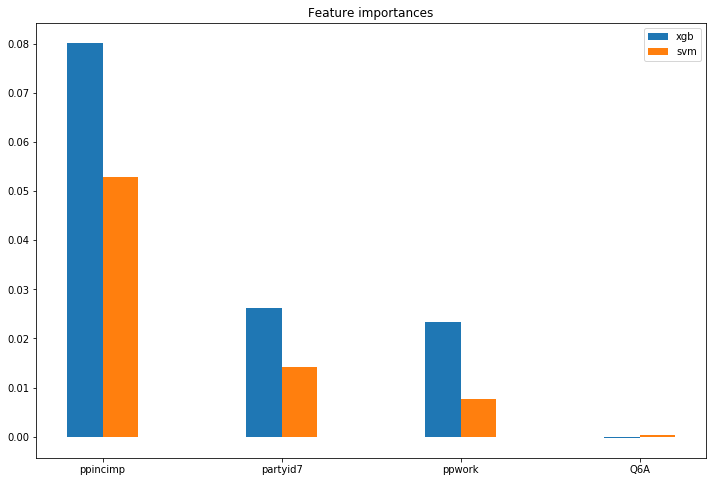

In [79]:
width = 0.2
plt.figure(figsize=(12,8))

plt.bar(np.arange(len(X.iloc[:, :-1].columns)), importances['xgb'].values(), width, label='xgb')
plt.bar(np.arange(len(X.iloc[:, :-1].columns)) + width, importances['svm'].values(), width, label='svm')

plt.xticks(np.array(range(len(importances['xgb']))) + width - 1/10, importances['xgb'].keys())
plt.title('Feature importances')
plt.legend()
plt.show()

Teraz skorzystam ze zrobionej podczas wcześniejszych prac domowych funkcji pd_plot. Pozwolę sobie porównać dwie zmienne, gdyż 'ppincimp' różni się najwięcej nominalnie, natomiast 'ppwork' procentowo. Warto spojrzeć na oba przypadki.

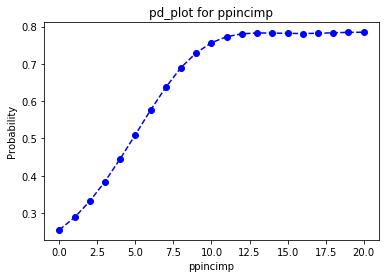

In [80]:
pd_plot(svm_model, X.iloc[:, :-1], 'ppincimp')

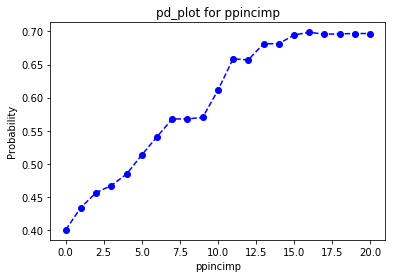

In [81]:
pd_plot(xgb_model, X.iloc[:, :-1], 'ppincimp')

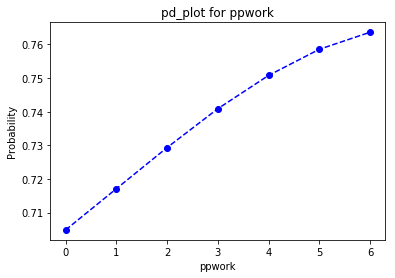

In [82]:
pd_plot(svm_model, X.iloc[:, :-1], 'ppwork')

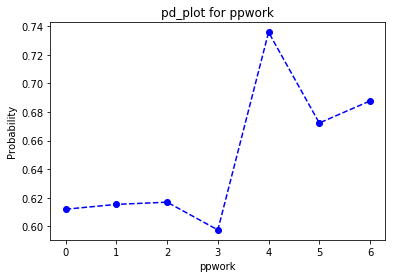

In [84]:
pd_plot(xgb_model, X.iloc[:, :-1], 'ppwork')

W pierwszym przypadku zmienna zachowuje się bardzo podobnie dla obu modeli. Większą wariancję prawdopodobieństwa ma model związany z xgboostem i ma "łamaną strukturę" ze względu na to, że jest to algorytm oparty na drzewach. W drugiej zmiennej mamy ciekawszą sytuację, gdyż tutaj zmienna w zależności od modelu przyjmuje zupełnie inne prawdopodobieństwa. Ogromna różnica między wyglądem jak i rozpiętością wartości prawdopodobieństwa przyjmowanych w obu modelach może wynikać z faktu, ze 'ppwork' dla modelu svm jest nieistotny i wpływ jest bliski 0, przez co rozróżnienie między poszczególnymi wartościami w tym modelu są znikome. Co ciekawe, pd_plot dla zmiennej ppwork w przypadku modelu xgboost mówi bardzo wiele i mówi bardzo intuicyjne rzeczy, gdyż największa zmiana jest między osobami, które